## <span style="color:#0b486b">Part 2: Deep Neural Networks (DNN) </span>
<div style="text-align: right"><span style="color:red">[Total marks for this part: 30 points]<span></div>

The first part of this assignment is for you to demonstrate your basis knowledge in deep learning that you have acquired from the lectures and tutorials materials. Most of the contents in this assignment are drawn from **the tutorials covered from weeks 1 to 5**. Going through these materials before attempting this assignment is highly recommended.

You are going to work with the **EMNIST** dataset for *image recognition task*. This dataset can be installed with the command <kbd>pip install emnist</kbd>. It has the exact same format as MNIST (grayscale images of 28 × 28 pixels), but the images represent handwritten letters rather than handwritten digits, so the problem is more challenging than MNIST.

### <span style="color:#0b486b">Question 2.1: Load the EMNIST datasets and process data</span> 


<div style="text-align: right"> <span style="color:red">[4 points]</span> </div>

We first use functions in the package **emnist**, namely <kbd>extract_training_samples</kbd> and <kbd>extract_test_samples</kbd>, to load the training and testing sets. We also want to encode labels using an ordinal encoding scheme.

In [1]:
import numpy as np
from emnist import extract_training_samples, extract_test_samples
from sklearn.preprocessing import LabelEncoder

In [2]:
X_train_raw, y_train_raw = extract_training_samples('letters')
X_test_raw, y_test_raw = extract_test_samples('letters')
print(X_train_raw.shape, y_train_raw.shape, X_test_raw.shape, y_test_raw.shape)

(124800, 28, 28) (124800,) (20800, 28, 28) (20800,)


In [3]:
le = LabelEncoder()
y_train_full = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

class_ids = np.unique(y_train_full)
n_classes = len(class_ids)
print(class_ids)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


The shape of training and testing data are $(num\_train, 28, 28)$ and $(num\_test, 28, 28)$, where $num\_train$ and $num\_test$ are number of training and testing images respectively. We next convert them to arrays of vectors which have shape $(num\_train, 784)$ and $(num\_test, 784)$.

In [4]:
num_train = X_train_raw.shape[0]
num_test = X_test_raw.shape[0]
X_train_full = X_train_raw.reshape(num_train,-1)
X_test = X_test_raw.reshape(num_test,-1)
print(X_train_full.shape, y_train_full.shape)
print(X_test.shape, y_test.shape)

(124800, 784) (124800,)
(20800, 784) (20800,)


### <span style="color:#0b486b">Question 2.2: Split data into training, validation, and testing datasets</span>

<div style="text-align: right"> <span style="color:red">[2 points]</span> </div>

You need to write the code to address the following requirements:
- Use $10 \%$ of `X_train_full`, `y_train_full` for validation and the rest of `X_train_full`, `y_train_full` for training. This splits `X_train_full` and `y_train_full` into `X_train`, `y_train` ($90 \%$) and `X_val`, `y_val` ($10 \%$).
- Finally, scale the pixels of `X_train`, `X_val`, and `X_test` to $[0,1]$) (i.e., $X = X/255.0$).

You have now the separate training, validation, and testing sets for training your model.



In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, train_size=0.9, test_size=0.1, random_state=42)

scaler = MinMaxScaler()
X_train, X_val, X_test = scaler.fit_transform(X_train), scaler.transform(X_val), scaler.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

print(X_train.min(), X_train.max(), X_val.min(), X_val.max(), X_test.min(), X_test.max())

(112320, 784) (112320,)
(12480, 784) (12480,)
(20800, 784) (20800,)
0.0 1.0 0.0 1.1025641025641026 0.0 37.0


### <span style="color:#0b486b">Question 2.3: Visualize some images in the training set with labels</span>

<div style="text-align: right"> <span style="color:red">[5 points]</span> </div>

You are required to write the code to **randomly** show $36$ images in X_train_full_img (which is an array of images) with labels as in the following figure.

<img src="Figures/emnist_grid.png" width="450" align="center"/>

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

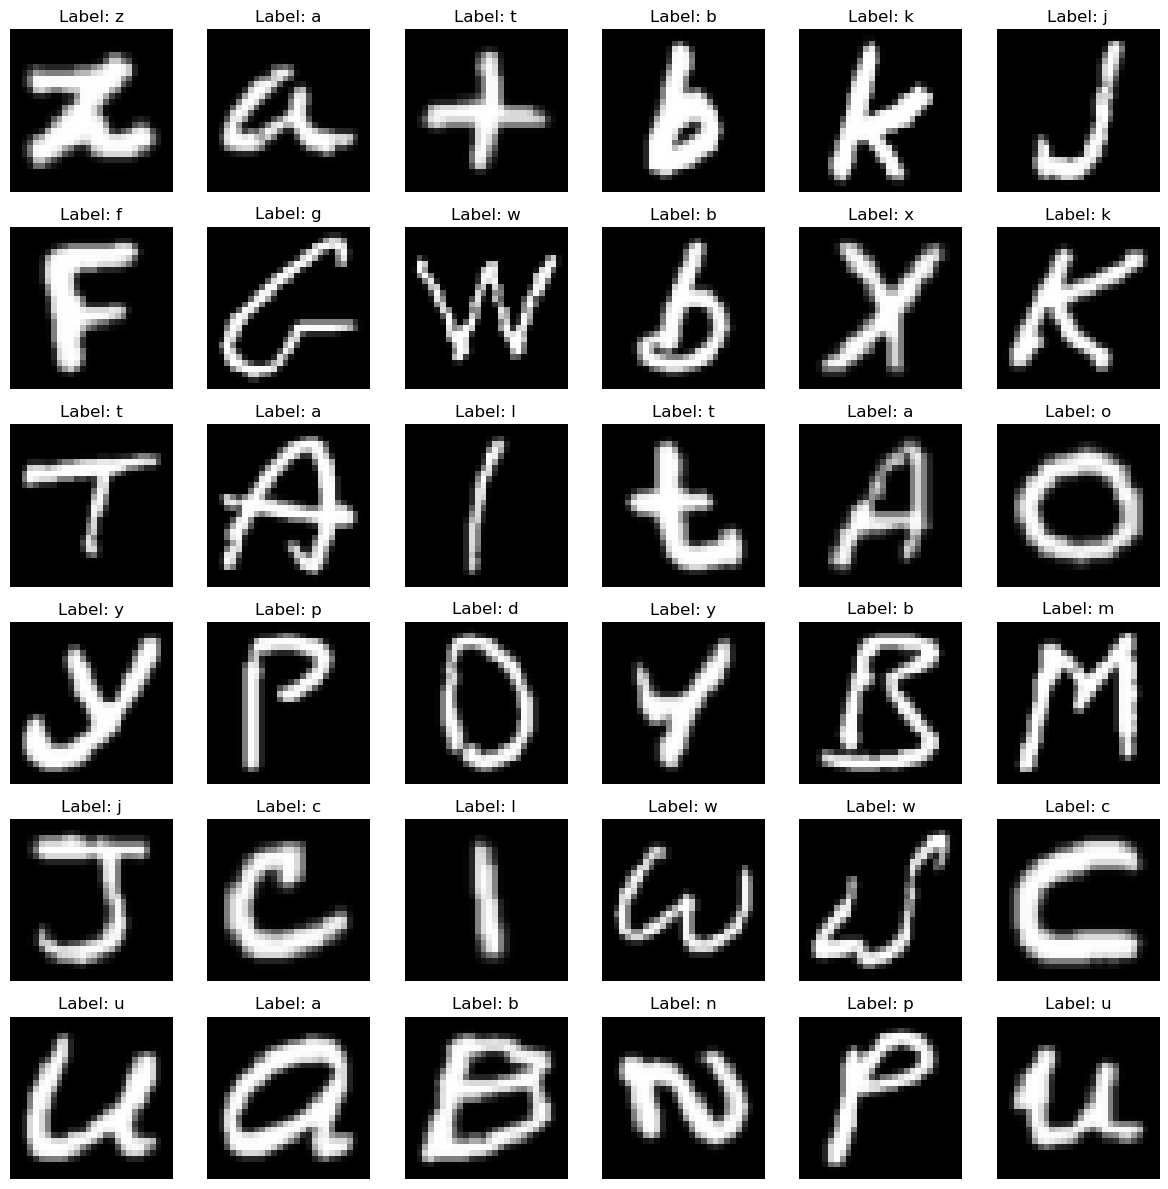

In [7]:
# Define the size of the grid
grid_size = (6, 6)

# Calculate the total number of images to display
total_images = grid_size[0] * grid_size[1]

# Create a list of random indices to select images
random_indices = np.random.choice(len(X_train), total_images, replace=False)

# Create a subplot grid for visualization
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 12))

# Iterate over the grid and plot the images
for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        ax = axes[i, j]
        idx = random_indices[i * grid_size[1] + j]
        image = X_train[idx].reshape(28, 28)
        label = chr(y_train[idx]+97)
        
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')

plt.tight_layout()
plt.show()


### <span style="color:#0b486b">Question 2.4: Write code for the feed-forward neural net using TF 2.x</span>

<div style="text-align: right"> <span style="color:red">[5 points]</span> </div>

We now develop a feed-forward neural network with the architecture $784 \rightarrow 20(ReLU) \rightarrow 40(ReLU) \rightarrow 10(softmax)$. You can choose your own way to implement your network and an optimizer of interest. You should train model in $20$ epochs and evaluate the trained model on the test set.

In [8]:
import tensorflow as tf
random_seed = 3181
tf.random.set_seed(random_seed)
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential

In [9]:
# Define the architecture of the neural network
dnn_model = Sequential()
dnn_model.add(Dense(units=20,  input_shape=(784,), activation='relu'))  # Flatten the input (28x28 images), First hidden layer with 20 neurons and ReLU activation
dnn_model.add(Dense(units=40, activation='relu'))  # Second hidden layer with 40 neurons and ReLU activation
dnn_model.add(Dense(units=10, activation='relu'))
dnn_model.add(Dense(units=len(np.unique(y_train)), activation='softmax'))  # Output layer with 10 neurons for classification

In [10]:
dnn_model.build()
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                15700     
                                                                 
 dense_1 (Dense)             (None, 40)                840       
                                                                 
 dense_2 (Dense)             (None, 10)                410       
                                                                 
 dense_3 (Dense)             (None, 26)                286       
                                                                 
Total params: 17,236
Trainable params: 17,236
Non-trainable params: 0
_________________________________________________________________


In [11]:
dnn_model.layers # returns a list of model layers

In [12]:
hidden1 = dnn_model.layers[0]
hidden1
print(hidden1.name) # returns the name of the first layer

dense


In [13]:
weights, biases = hidden1.get_weights()
weights.shape, biases.shape # returns the dimensions of the weight matrix and bias vector at the first layer

((784, 20), (20,))

In [14]:
dnn_model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

In [15]:
from tensorflow import keras
logdir = "tf_logs/example01"

# Init a tensorboard_callback 
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Call the fit method, passing the tensorboard_callback 
history = dnn_model.fit(x=X_train, y=y_train, batch_size=32, 
                        epochs=20, 
                        validation_data=(X_val, y_val), 
                       callbacks=[tensorboard_callback])

Epoch 1/20
3510/3510 [==============================] - 5s 1ms/step - loss: 1.3940 - accuracy: 0.5867 - val_loss: 1.0304 - val_accuracy: 0.6837
Epoch 2/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.8970 - accuracy: 0.7319 - val_loss: 0.8683 - val_accuracy: 0.7430
Epoch 3/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.7945 - accuracy: 0.7632 - val_loss: 0.7831 - val_accuracy: 0.7675
Epoch 4/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.7304 - accuracy: 0.7804 - val_loss: 0.7323 - val_accuracy: 0.7835
Epoch 5/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.6916 - accuracy: 0.7914 - val_loss: 0.6914 - val_accuracy: 0.7951
Epoch 6/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.6650 - accuracy: 0.7996 - val_loss: 0.6655 - val_accuracy: 0.7992
Epoch 7/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.6416 - accuracy: 0.8054 - val_loss: 0.6600 - val_accuracy:

### <span style="color:#0b486b">Question 2.5: Tuning hyper-parameters with grid search</span>
<div style="text-align: right"> <span style="color:red">[6 points]</span> </div>

Assume that you need to tune the number of neurons on the first and second hidden layers $n_1 \in \{20, 40\}$, $n_2 \in \{20, 40\}$  and the used activation function  $act \in \{sigmoid, tanh, relu\}$. The network has the architecture pattern $784 \rightarrow n_1 (act) \rightarrow n_2(act) \rightarrow 10(softmax)$ where $n_1, n_2$, and $act$ are in their grides. Write the code to tune the hyper-parameters $n_1, n_2$, and $act$. Note that you can freely choose the optimizer and learning rate of interest for this task.

Best n1: 40, 
Best n2: 40, 
Best activation function: relu, 
Best validation accuracy: 0.8582531809806824

In [16]:
from sklearn.metrics import accuracy_score

# Define the range of values for n1, n2, and activation
n1_values = [20, 40]
n2_values = [20, 40]
activation_functions = ['sigmoid', 'tanh', 'relu']

# Initialize variables to store the best hyperparameters and accuracy
best_n1 = None
best_n2 = None
best_activation = None
best_accuracy = 0.0

# Load the data and preprocess as you did before

# Loop through different combinations of hyperparameters
for i in n1_values:
    for j in n2_values:
        for act in activation_functions:
            # Build and compile the model
            model = Sequential()
            model.add(Dense(units=i, input_shape=(784,), activation=act))
            model.add(Dense(units=j, activation=act))
            model.add(Dense(units=10, activation='relu'))
            model.add(Dense(units=len(np.unique(y_train)), activation='softmax'))
            model.compile(optimizer='adam', 
                              loss='sparse_categorical_crossentropy', 
                              metrics=['accuracy'])
            logdir1 = "tf_logs/example02"

# Init a tensorboard_callback 
            tensorboard_callback1 = keras.callbacks.TensorBoard(log_dir=logdir1)

# Call the fit method, passing the tensorboard_callback 

            history = model.fit(x=X_train, y=y_train, batch_size=32, 
                                epochs=20,
                                validation_data=(X_val, y_val),
                                callbacks=[tensorboard_callback1])
            
            # Evaluate the model on the validation set
            val_loss, val_accuracy = model.evaluate(X_val, y_val)
            # Check if the current model has a higher validation accuracy
            if val_accuracy > best_accuracy:
                best_n1 = i
                best_n2 = j
                best_activation = act
                best_accuracy = val_accuracy

# Print the best hyperparameters and accuracy
print(f"Best n1: {best_n1}")
print(f"Best n2: {best_n2}")
print(f"Best activation function: {best_activation}")
print(f"Best validation accuracy: {best_accuracy}")

# Now, you can train the final model using the best hyperparameters on the entire training set and evaluate it on the test set.


Epoch 1/20
3510/3510 [==============================] - 5s 1ms/step - loss: 2.0285 - accuracy: 0.4007 - val_loss: 1.4902 - val_accuracy: 0.5674
Epoch 2/20
3510/3510 [==============================] - 4s 1ms/step - loss: 1.3153 - accuracy: 0.6095 - val_loss: 1.2201 - val_accuracy: 0.6391
Epoch 3/20
3510/3510 [==============================] - 4s 1ms/step - loss: 1.1444 - accuracy: 0.6598 - val_loss: 1.1191 - val_accuracy: 0.6700
Epoch 4/20
3510/3510 [==============================] - 4s 1ms/step - loss: 1.0602 - accuracy: 0.6840 - val_loss: 1.0573 - val_accuracy: 0.6879
Epoch 5/20
3510/3510 [==============================] - 4s 1ms/step - loss: 1.0021 - accuracy: 0.7002 - val_loss: 1.0218 - val_accuracy: 0.6982
Epoch 6/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.9579 - accuracy: 0.7140 - val_loss: 0.9838 - val_accuracy: 0.7151
Epoch 7/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.9186 - accuracy: 0.7252 - val_loss: 0.9382 - val_accuracy:

3510/3510 [==============================] - 4s 1ms/step - loss: 0.6297 - accuracy: 0.8087 - val_loss: 0.6811 - val_accuracy: 0.8001
Epoch 17/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.6248 - accuracy: 0.8111 - val_loss: 0.6710 - val_accuracy: 0.7986
Epoch 18/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.6207 - accuracy: 0.8118 - val_loss: 0.6625 - val_accuracy: 0.8056
Epoch 19/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.6149 - accuracy: 0.8136 - val_loss: 0.6661 - val_accuracy: 0.8022
Epoch 20/20
390/390 [==============================] - 0s 923us/step - loss: 0.6603 - accuracy: 0.8033
Epoch 1/20
3510/3510 [==============================] - 5s 1ms/step - loss: 1.9329 - accuracy: 0.4164 - val_loss: 1.4586 - val_accuracy: 0.5589
Epoch 2/20
3510/3510 [==============================] - 4s 1ms/step - loss: 1.3199 - accuracy: 0.6071 - val_loss: 1.2647 - val_accuracy: 0.6353
Epoch 3/20
3510/3510 [===================

Epoch 11/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.5738 - accuracy: 0.8270 - val_loss: 0.5929 - val_accuracy: 0.8246
Epoch 12/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.5652 - accuracy: 0.8295 - val_loss: 0.5907 - val_accuracy: 0.8236
Epoch 13/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.5557 - accuracy: 0.8323 - val_loss: 0.5881 - val_accuracy: 0.8238
Epoch 14/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.5503 - accuracy: 0.8342 - val_loss: 0.5774 - val_accuracy: 0.8274
Epoch 15/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.5421 - accuracy: 0.8355 - val_loss: 0.5884 - val_accuracy: 0.8258
Epoch 16/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.5360 - accuracy: 0.8366 - val_loss: 0.5680 - val_accuracy: 0.8297
Epoch 17/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.5311 - accuracy: 0.8384 - val_loss: 0.5827 - val_ac

Epoch 6/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.5634 - accuracy: 0.8292 - val_loss: 0.6110 - val_accuracy: 0.8172
Epoch 7/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.5431 - accuracy: 0.8348 - val_loss: 0.6014 - val_accuracy: 0.8211
Epoch 8/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.5280 - accuracy: 0.8384 - val_loss: 0.5984 - val_accuracy: 0.8206
Epoch 9/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.5145 - accuracy: 0.8420 - val_loss: 0.5525 - val_accuracy: 0.8353
Epoch 10/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.5031 - accuracy: 0.8456 - val_loss: 0.5467 - val_accuracy: 0.8363
Epoch 11/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.4910 - accuracy: 0.8500 - val_loss: 0.5405 - val_accuracy: 0.8403
Epoch 12/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.4816 - accuracy: 0.8508 - val_loss: 0.5398 - val_accura

390/390 [==============================] - 0s 921us/step - loss: 0.5382 - accuracy: 0.8413
Epoch 1/20
3510/3510 [==============================] - 5s 1ms/step - loss: 1.1927 - accuracy: 0.6491 - val_loss: 0.7959 - val_accuracy: 0.7665
Epoch 2/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.7012 - accuracy: 0.7915 - val_loss: 0.6544 - val_accuracy: 0.8026
Epoch 3/20
3510/3510 [==============================] - 5s 1ms/step - loss: 0.6058 - accuracy: 0.8173 - val_loss: 0.5692 - val_accuracy: 0.8290
Epoch 4/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.5541 - accuracy: 0.8328 - val_loss: 0.5601 - val_accuracy: 0.8314
Epoch 5/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.5204 - accuracy: 0.8426 - val_loss: 0.5271 - val_accuracy: 0.8399
Epoch 6/20
3510/3510 [==============================] - 4s 1ms/step - loss: 0.4968 - accuracy: 0.8482 - val_loss: 0.5174 - val_accuracy: 0.8425
Epoch 7/20
3510/3510 [=======================

### <span style="color:#0b486b">Question 2.6: Experimenting with the **label smoothing** technique</span>
<div style="text-align: right"> <span style="color:red">[8 points]</span> </div>

Implement the label smoothing technique (i.e., [link for main paper](https://papers.nips.cc/paper/2019/file/f1748d6b0fd9d439f71450117eba2725-Paper.pdf) from Goeff Hinton) by yourself. Note that you cannot use the built-in label-smoothing loss function in TF2.x. Try the label smoothing technique with $\alpha =0.1, 0.15, 0.2$ and report the performances. You need to examine the label smoothing technique with the best architecture obtained in **Question 2.5**.

Alpha = 0.1:
Accuracy = 0.8606250286102295

Alpha = 0.15:
Accuracy = 0.8630288243293762

Alpha = 0.2:
Accuracy = 0.8632692098617554

Increasing the value of 𝛼 from 0.1 to 0.2 has a positive impact on accuracy, indicating that label smoothing is helping the model perform better. The higher 𝛼 value (0.2) redistributes more probability mass from the true class to other classes, making the model less overconfident and more likely to generalize well.

The accuracy improvement from 𝛼=0.1 to 𝛼=0.2 is relatively small, but it still demonstrates that label smoothing with 𝛼=0.2 provides a slightly better regularization effect compared to 𝛼=0.1.

Across all three 𝛼 values, the model performs reasonably well, with accuracy values in the range of 0.86 to 0.87. This suggests that label smoothing is effective in preventing overfitting and improving the model's generalization capability.

The choice of the optimal 𝛼 value may depend on your specific dataset and task. In this case, 𝛼=0.2 yielded the highest accuracy, but you might want to experiment with different values of 𝛼 to see if further improvements are possible or if a different value is more suitable for your task.

In summary, label smoothing with 𝛼 values of 0.1, 0.15, and 0.2 all contributed to better model performance, with 𝛼=0.2 achieving the highest accuracy. The choice of 𝛼 should be based on careful experimentation and consideration of the trade-off between regularization strength and model accuracy.

In [19]:
def label_smoothed_loss(alpha):
    def loss(y_true, y_pred):
        num_classes = y_pred.shape[-1]
        y_true_smooth = (1.0 - alpha) * y_true + alpha / num_classes
        return tf.keras.losses.categorical_crossentropy(y_true_smooth, y_pred, from_logits=False)
    return loss

In [20]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

# Define the best architecture obtained
best_model = Sequential()
best_model.add(Dense(units=best_n1, input_shape=(784,), activation=best_activation))
best_model.add(Dense(units=best_n2, activation=best_activation))
best_model.add(Dense(units=10, activation='relu'))
best_model.add(Dense(units=len(np.unique(y_train)), activation='softmax'))
best_model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',  # Use categorical cross-entropy for label smoothing
                  metrics=['accuracy'])



# Loop through different alpha values
alpha_values = [0.1, 0.15, 0.2]
for alpha in alpha_values:
    print(f"Alpha: {alpha}")
    
    # Convert integer labels to one-hot encoded labels for label smoothing
    y_train_onehot = to_categorical(y_train, num_classes=len(np.unique(y_train)))
    y_val_onehot = to_categorical(y_val, num_classes=len(np.unique(y_val)))
    y_test_onehot = to_categorical(y_test, num_classes=len(np.unique(y_test)))  # Add this line

    # Train the model with label smoothing
    best_model.compile(optimizer='adam', 
                      loss=label_smoothed_loss(alpha),  # Use label_smoothed_loss with alpha
                      metrics=['accuracy'])
    history = best_model.fit(x=X_train, y=y_train_onehot, batch_size=32, 
                            epochs=20,  # Train for 1 epochs
                            validation_data=(X_val, y_val_onehot),
                            callbacks=[tensorboard_callback1])

    # Evaluate the model on the test set
    test_loss, test_accuracy = best_model.evaluate(X_test, y_test_onehot)
    print(f"Test Accuracy (Alpha = {alpha}): {test_accuracy}")


Alpha: 0.1
Epoch 1/20
3510/3510 [==============================] - 6s 1ms/step - loss: 1.6897 - accuracy: 0.6515 - val_loss: 1.4228 - val_accuracy: 0.7592
Epoch 2/20
3510/3510 [==============================] - 4s 1ms/step - loss: 1.3366 - accuracy: 0.7896 - val_loss: 1.3143 - val_accuracy: 0.7977
Epoch 3/20
3510/3510 [==============================] - 4s 1ms/step - loss: 1.2591 - accuracy: 0.8160 - val_loss: 1.2479 - val_accuracy: 0.8202
Epoch 4/20
3510/3510 [==============================] - 4s 1ms/step - loss: 1.2179 - accuracy: 0.8289 - val_loss: 1.2199 - val_accuracy: 0.8262
Epoch 5/20
3510/3510 [==============================] - 5s 1ms/step - loss: 1.1898 - accuracy: 0.8383 - val_loss: 1.1936 - val_accuracy: 0.8349
Epoch 6/20
3510/3510 [==============================] - 4s 1ms/step - loss: 1.1683 - accuracy: 0.8449 - val_loss: 1.1798 - val_accuracy: 0.8398
Epoch 7/20
3510/3510 [==============================] - 5s 1ms/step - loss: 1.1505 - accuracy: 0.8502 - val_loss: 1.1715 - va

3510/3510 [==============================] - 4s 1ms/step - loss: 1.4731 - accuracy: 0.8896 - val_loss: 1.5261 - val_accuracy: 0.8671
Epoch 16/20
3510/3510 [==============================] - 5s 1ms/step - loss: 1.4724 - accuracy: 0.8908 - val_loss: 1.5233 - val_accuracy: 0.8646
Epoch 17/20
3510/3510 [==============================] - 5s 1ms/step - loss: 1.4719 - accuracy: 0.8904 - val_loss: 1.5265 - val_accuracy: 0.8616
Epoch 18/20
3510/3510 [==============================] - 4s 1ms/step - loss: 1.4708 - accuracy: 0.8909 - val_loss: 1.5254 - val_accuracy: 0.8640
Epoch 19/20
3510/3510 [==============================] - 5s 1ms/step - loss: 1.4699 - accuracy: 0.8911 - val_loss: 1.5286 - val_accuracy: 0.8627
Epoch 20/20
650/650 [==============================] - 1s 983us/step - loss: 1.5276 - accuracy: 0.8633
Test Accuracy (Alpha = 0.2): 0.8632692098617554
